**consistency regularization**

MixMatch's augment
: random perturbation 추가하기 & ramp up 

1 supervised, unsupervised (FC layer)

2 decision boundary 구분하기

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons

In [438]:
X, y = make_moons(n_samples=5000, noise=0.1)

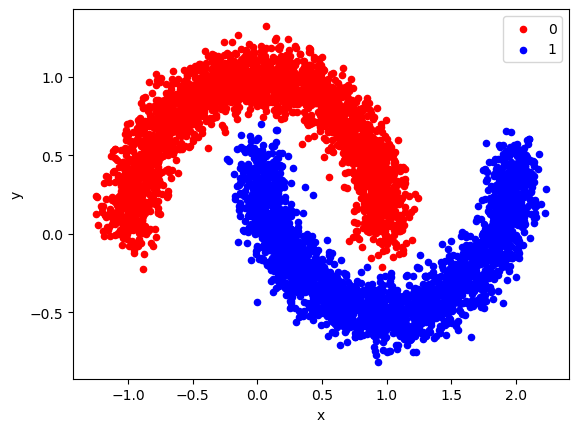

In [439]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))
colors= {0: 'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [440]:
df

,x,y,label
0,1.700844,-0.419729,1
1,0.100853,0.378652,1
2,1.904300,0.501899,1
3,0.327684,-0.222076,1
4,1.116944,-0.081071,0
...,...,...,...
4995,0.367514,-0.274995,1
4996,1.861154,0.095623,1
4997,1.914296,0.499129,1
4998,0.496209,-0.231785,1


In [441]:
target = df.label
df.drop(['label'], axis=1, inplace=True)

X = df
y = target

In [442]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4000, 2), (4000,), (1000, 2), (1000,))

In [443]:
# Train unsupervised / Train supervised split (unlabel : 80%)
# Train set / Validation set split
X_train, X_u_train, y_train, y_u_train = train_test_split(X_train, y_train, test_size=0.99, random_state=1,
                                                          shuffle=True, stratify=y_train)
X_train.shape, X_u_train.shape, y_train.shape, y_u_train.shape

((40, 2), (3960, 2), (40,), (3960,))

### Original

In [444]:
# dataset
import torch
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor.to_numpy()
        self.y = y_tensor.to_numpy()
        
    def __getitem__(self, index):
        x = self.x[index:index+1]
        y = self.y[index:index+1]
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        x = x.view(-1, )
        return x, y

    def __len__(self):
        return len(self.x)

class BasicDataset2(data.Dataset):
    def __init__(self, x_tensor):
        super(BasicDataset2, self).__init__()

        self.x = x_tensor.to_numpy()
        # self.y = y_tensor.to_numpy()
        
    def __getitem__(self, index):
        x = self.x[index:index+1]
        # y = self.y[index:index+1]
        x = torch.FloatTensor(x)
        # y = torch.FloatTensor(y)
        x = x.view(-1, )
        return x

    def __len__(self):
        return len(self.x)

In [445]:
# dataloader
from torch.utils.data import DataLoader

train_dataset = BasicDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [446]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 1, bias=True)
        #self.sig1 = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        #x = self.sig1(x)

        return x

In [447]:
model = Net()

In [448]:
#device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
model.to(device)

Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [449]:
import torch.optim as optim

criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [450]:
train_dataset = BasicDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
unlabeled_dataset = BasicDataset2(X_u_train)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=200, shuffle=True) 

In [451]:
print(train_dataloader.__len__())
print(unlabeled_dataloader.__len__())

20
20


test 1

In [452]:
for epoch in range(100):
    cost = 0.0
    model.train()

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        sig = nn.Sigmoid()
        output = sig(output)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
    
    cost = cost / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost : {cost:.3f}")

Epoch :   10,  Cost : 0.118
Epoch :   20,  Cost : 0.028
Epoch :   30,  Cost : 0.011
Epoch :   40,  Cost : 0.005
Epoch :   50,  Cost : 0.002
Epoch :   60,  Cost : 0.001
Epoch :   70,  Cost : 0.001
Epoch :   80,  Cost : 0.001
Epoch :   90,  Cost : 0.000
Epoch :  100,  Cost : 0.000


In [453]:
test_dataset = BasicDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def test(model, test_gen):
    model.eval()
    acc = []
    y = []
    pred = []
    for i, (x, y) in enumerate(test_gen):
        x = x.to(device)
        pred = model(x).to('cpu')
        pred = pred.detach().numpy()
        y = y.detach().numpy()
        for i in range(len(pred)):
            if pred[i] > 0.5:
                pred[i] = 1
            else:
                pred[i] = 0
        acc = accuracy_score(y, pred)
        if i % 5 == 0:
            print(i ,acc)
        y = y
        pred = pred
    print('Accuracy was : {}'.format(np.mean(acc)))
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))

In [454]:
test(model, test_dataloader)

Accuracy was : 1.0
[[5 0]
 [0 3]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



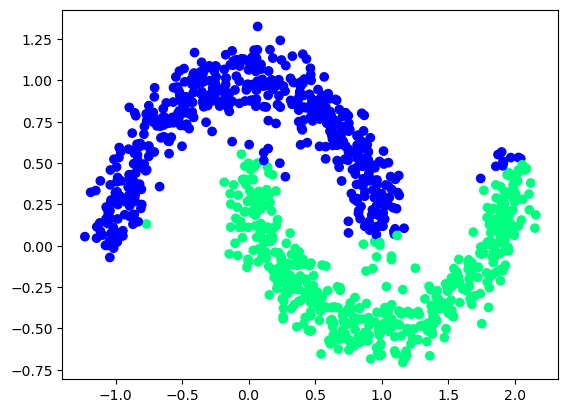

In [455]:
for i, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    pred = model(x)
    x = x.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    plt.scatter(x=x[:, 0], y=x[:, 1], c=pred, cmap=plt.cm.winter)

### MixMatch

In [456]:
a = torch.randn([4,2])
print(a)
noise1 = np.random.normal(0, 0.1)
print(a + noise1)
noise2 = np.random.normal(0, 0.1, size=(a.shape[0], a.shape[1]))
noise2 = torch.tensor(noise2, dtype=torch.float32)
print(a + noise2)

tensor([[-0.8787,  0.8559],
        [-2.6072, -1.8792],
        [ 1.0674,  0.5413],
        [-1.7279, -0.4085]])
tensor([[-0.9070,  0.8276],
        [-2.6355, -1.9074],
        [ 1.0392,  0.5131],
        [-1.7562, -0.4368]])
tensor([[-0.7683,  0.7597],
        [-2.7602, -1.7892],
        [ 1.1329,  0.3585],
        [-1.7324, -0.3244]])


In [457]:
def augment(points_x):
    #noise = np.random.normal(0, 0.1)
    
    noise = np.random.normal(0, 0.1, size=(points_x.shape[0], points_x.shape[1]))
    noise = torch.tensor(noise, dtype=torch.float32)
    
    return points_x + noise

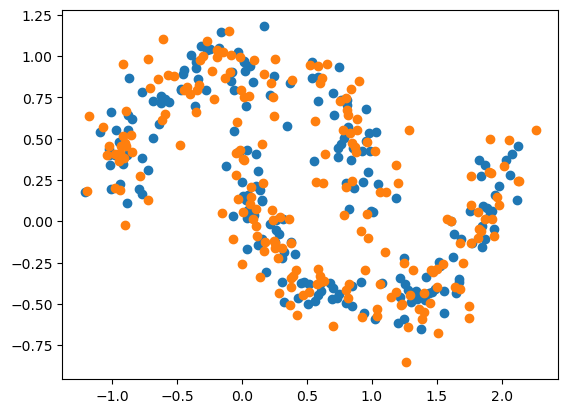

In [458]:
# augment test
x = next(iter(unlabeled_dataloader))
x_a = augment(x)

plt.scatter(x=x[:, 0], y=x[:, 1], )
plt.scatter(x=x_a[:, 0], y=x_a[:, 1], )

In [459]:
def sharpen(x, T):
    temp = x**(1/T)
    return temp / temp.sum(axis=1, keepdims=True)

In [460]:
def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, alpha)
    lam = max(beta, 1-beta) # 딱히 의미는 없지만 논문대로 구현하려고
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

In [461]:
class MixMatchLoss(torch.nn.Module):
    def __init__(self):
        super(MixMatchLoss, self).__init__()
        self.xent = torch.nn.BCELoss()
        self.mse = torch.nn.MSELoss()
        self.sig = torch.nn.Sigmoid()
    
    def forward(self, X, U, p, q, model, ramp):
        X_ = torch.cat([X, U], axis=0)
        preds = model(X_)

        # bce loss 이전에 sigmoid
        preds[:len(p)] = self.sig(preds[:len(p)])
        return self.xent(preds[:len(p)], p) + ramp * self.mse(preds[len(p):], q)

In [462]:
def mixmatch(x, y, u, model, T=0.5, K=2, alpha=0.75):
    xb = augment(x)
    ub = [augment(u) for _ in range(K)]
    # qb = sharpen(sum(map(lambda i: model(i), ub)) / K, T) -> binary니까 sharpen X

    qb = sum(map(lambda i: model(i), ub)) / K

    Ux = torch.cat(ub, axis=0) # unlabel x
    Uy = torch.cat([qb for _ in range(K)], axis=0) # unlabel y (label 만든걸 k개씩 할당해주기)

    # indices = torch.randperm(len(xb)+len(Ux)) # label x + unlabel x 데이터 전체 개수

    # Wx = torch.cat([Ux, xb], axis=0)[indices] # unlabel + label x
    # Wy = torch.cat([qb, y], axis=0)[indices] # unlabel + label y를 각자 indices만큼 잘라 = 그냥 모델 전체 개수임
    
    # X, p = mixup(xb, Wx[:len(xb)], y, Wy[:len(xb)], alpha) # label과 W를 mixup
    # U, q = mixup(Ux, Wx[len(xb):], Uy, Wy[len(xb):], alpha) # unlabel과 W를 mixup => 제거하자

    X = xb
    U = Ux
    p = y
    q = Uy
    

    return X, U, p, q

### train

1 단순히 noise augment 만 할 경우

In [463]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [464]:
for epoch in range(100):
    cost = 0.0
    model.train()

    for x, y in train_dataloader:

        x = augment(x)

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        output = sig(output)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
    
    cost = cost / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost : {cost:.3f}")

Epoch :   10,  Cost : 0.145
Epoch :   20,  Cost : 0.049
Epoch :   30,  Cost : 0.045
Epoch :   40,  Cost : 0.007
Epoch :   50,  Cost : 0.008
Epoch :   60,  Cost : 0.008
Epoch :   70,  Cost : 0.010
Epoch :   80,  Cost : 0.065
Epoch :   90,  Cost : 0.006
Epoch :  100,  Cost : 0.004


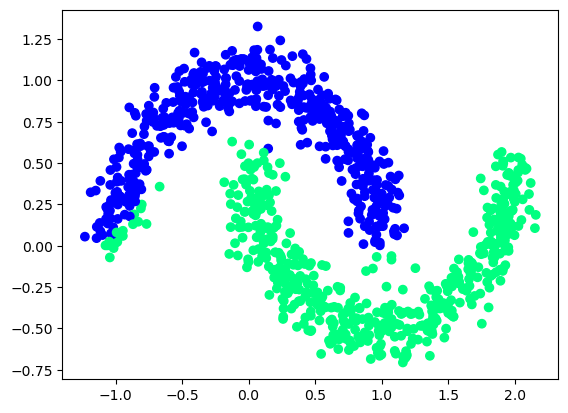

In [465]:
for i, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    pred = model(x)
    x = x.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    plt.scatter(x=x[:, 0], y=x[:, 1], c=pred, cmap=plt.cm.winter)

2 mixmatch

In [466]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [467]:
epochs = 300
per = epochs/5

for epoch in range(epochs):
    cost = 0.0
    model.train()

    
    # ramp up
    if epoch < per:
        ramp = 1
    elif epoch < per*2: 
        ramp = 5
    elif epoch < per*3: 
        ramp = 10
    elif epoch < per*4:
        ramp = 15
    else:
        ramp = 20

    #print(ramp)

    for _ in range(len(train_dataloader)):

        xi, yi = next(iter(train_dataloader))
        ui = next(iter(unlabeled_dataloader))
        
        # print(xi)

        xi = xi.to(device)
        yi = yi.to(device)
        ui = ui.to(device)
        
        X, U, p, q = mixmatch(xi, yi, ui, model, augment)

        # print(X,U,p,q)

        criterion = MixMatchLoss()
        loss = criterion(X, U, p, q, model, ramp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
        
    cost = cost / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost : {cost:.3f}")

Epoch :   10,  Cost : 0.266
Epoch :   20,  Cost : 0.205
Epoch :   30,  Cost : 0.148
Epoch :   40,  Cost : 0.143
Epoch :   50,  Cost : 0.181
Epoch :   60,  Cost : 0.128
Epoch :   70,  Cost : 0.239
Epoch :   80,  Cost : 0.266
Epoch :   90,  Cost : 0.236
Epoch :  100,  Cost : 0.248
Epoch :  110,  Cost : 0.242
Epoch :  120,  Cost : 0.219
Epoch :  130,  Cost : 0.343
Epoch :  140,  Cost : 0.310
Epoch :  150,  Cost : 0.324
Epoch :  160,  Cost : 0.306
Epoch :  170,  Cost : 0.322
Epoch :  180,  Cost : 0.277
Epoch :  190,  Cost : 0.372
Epoch :  200,  Cost : 0.373
Epoch :  210,  Cost : 0.428
Epoch :  220,  Cost : 0.403
Epoch :  230,  Cost : 0.363
Epoch :  240,  Cost : 0.390
Epoch :  250,  Cost : 0.400
Epoch :  260,  Cost : 0.368
Epoch :  270,  Cost : 0.411
Epoch :  280,  Cost : 0.452
Epoch :  290,  Cost : 0.420
Epoch :  300,  Cost : 0.439


### test

In [468]:
test_dataset = BasicDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [469]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def test(model, test_gen):
    model.eval()
    acc = []
    y = []
    pred = []
    for i, (x, y) in enumerate(test_gen):
        x = x.to(device)
        pred = model(x).to('cpu')
        pred = pred.detach().numpy()
        y = y.detach().numpy()
        for i in range(len(pred)):
            if pred[i] > 0.5:
                pred[i] = 1
            else:
                pred[i] = 0
        acc = accuracy_score(y, pred)
        if i % 5 == 0:
            print(i ,acc)
        y = y
        pred = pred
    print('Accuracy was : {}'.format(np.mean(acc)))
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))

In [470]:
test(model, test_dataloader)

Accuracy was : 1.0
[[4 0]
 [0 4]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



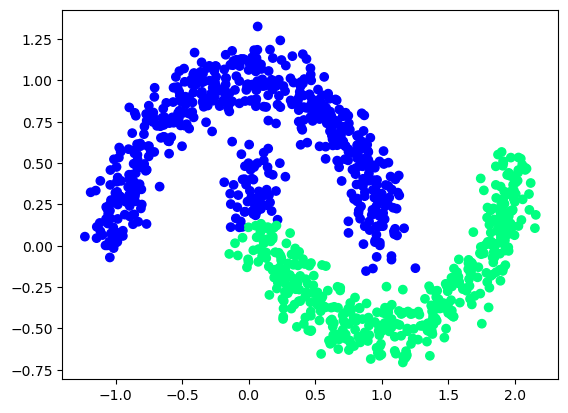

In [471]:
for i, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    pred = model(x)
    x = x.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    plt.scatter(x=x[:, 0], y=x[:, 1], c=pred, cmap=plt.cm.winter)